Integrantes: Diego de la Sotta, Juan Mamani, Matias Torres y Benjamín Espinoza

In [ ]:
!pip install pandas matplotlib wordcloud transformers torch seaborn
!pip3 install emoji==0.6.0
!pip install nest_asyncio
!pip install asyncio
!pip install playwright
!playwright install



  Using cached playwright-1.49.0-py3-none-manylinux1_x86_64.whl.metadata (3.5 kB)
  Using cached pyee-12.0.0-py3-none-any.whl.metadata (2.8 kB)
Using cached playwright-1.49.0-py3-none-manylinux1_x86_64.whl (44.1 MB)
Using cached pyee-12.0.0-py3-none-any.whl (14 kB)
161.3 MiB [] 0% 0.0s161.3 MiB [] 0% 43.6s161.3 MiB [] 0% 35.7s161.3 MiB [] 0% 18.0s161.3 MiB [] 0% 8.1s161.3 MiB [] 1% 5.4s161.3 MiB [] 2% 4.0s161.3 MiB [] 3% 3.4s161.3 MiB [] 4% 3.1s161.3 MiB [] 5% 2.8s161.3 MiB [] 5% 2.7s161.3 MiB [] 6% 2.8s161.3 MiB [] 7% 2.7s161.3 MiB [] 8% 2.6s161.3 MiB [] 9% 2.5s161.3 MiB [] 10% 2.5s161.3 MiB [] 11% 2.4s161.3 MiB [] 13% 2.2s161.3 MiB [] 14% 2.1s161.3 MiB [] 15% 2.0s161.3 MiB [] 17% 1.9s161.3 MiB [] 18% 1.8s161.3 MiB [] 19% 1.8s161.3 MiB [] 20% 1.7s161.3 MiB [] 22% 1.6s161.3 MiB [] 23% 1.6s161.3 MiB [] 23% 1.7s161.3 MiB [] 24% 1.6s161.3 MiB [] 25% 1.7s161.3 MiB [] 26% 1.7s161.3 MiB [] 27% 1.6s161.3 MiB [] 28% 1.6s161.3 MiB [] 29% 1.6s161.3 MiB [] 29% 1.7s161.3 MiB [] 29% 1.8s161.3 MiB [

In [ ]:
import asyncio
from playwright.async_api import async_playwright
import json
import pandas as pd
import random
import time
import nest_asyncio
from urllib.parse import urlparse

# Permite la ejecución de asyncio en entornos que ya tienen un bucle de eventos activo, como Jupyter Notebooks.
nest_asyncio.apply()


# Función para cargar cookies desde un archivo
async def load_cookies(context, cookies_path="cookiesMudryk.json"):
    try:
        with open(cookies_path, "r") as f:
            cookies = json.load(f)

        # Validar y corregir las cookies
        for cookie in cookies:
            if "sameSite" in cookie:
                if cookie["sameSite"] not in ["Strict", "Lax", "None"]:
                    print(f"Corrigiendo valor de sameSite en cookie: {cookie}")
                    cookie["sameSite"] = "Lax"  # Valor por defecto si es inválido

        # Añadir cookies al contexto del navegador
        await context.add_cookies(cookies)
        print("Cookies cargadas exitosamente.")
    except FileNotFoundError:
        print(f"Archivo {cookies_path} no encontrado. Procediendo sin cookies.")
    except Exception as e:
        print(f"Error al cargar las cookies: {e}")


# Función para guardar cookies en un archivo
async def save_cookies(context, cookies_path="cookiesMudryk.json"):
    cookies = await context.cookies()
    with open(cookies_path, "w") as f:
        json.dump(cookies, f)
    print(f"Cookies guardadas en {cookies_path}.")


# Función para obtener los enlaces de tweets relevantes basados en palabras clave
async def get_tweet_links(username, keywords, max_tweets):
    tweet_links = set()  # Conjunto para evitar duplicados
    unique_tweet_ids = set()
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        context = await browser.new_context()
        await load_cookies(context)
        page = await context.new_page()

        # Crear la consulta de búsqueda con las palabras clave
        search_query = f"from:{username} " + " OR ".join(keywords)
        search_url = f"https://x.com/search?q={search_query}&src=typed_query&f=live"
        print(f"Buscando tweets en: {search_url}")
        await page.goto(search_url)

        scroll_attempts = 0
        max_scroll_attempts = 20  # Número máximo de intentos de scroll

        while len(tweet_links) < max_tweets and scroll_attempts < max_scroll_attempts:
            # Seleccionar elementos de tweets que contienen enlaces a estados (tweets)
            tweet_elements = await page.query_selector_all('a[role="link"][href*="/status/"]')
            for tweet_element in tweet_elements:
                tweet_href = await tweet_element.get_attribute("href")
                if tweet_href:
                    parsed_url = urlparse(tweet_href)
                    path_segments = parsed_url.path.split("/")
                    tweet_id = path_segments[-1] if len(path_segments) > 1 else None

                    # Filtrar enlaces irrelevantes como "/photo", "/analytics", etc.
                    if (
                        tweet_id
                        and tweet_id not in unique_tweet_ids
                        and "/photo" not in tweet_href
                        and "/analytics" not in tweet_href
                        and "/video" not in tweet_href
                        and "/media_tags" not in tweet_href
                    ):
                        tweet_links.add(f"https://x.com{tweet_href}")
                        unique_tweet_ids.add(tweet_id)
                        if len(tweet_links) >= max_tweets:
                            break

            # Hacer scroll para cargar más contenido
            await page.evaluate("window.scrollBy(0, window.innerHeight);")
            await page.wait_for_timeout(random.randint(2000, 5000))  # Pausa aleatoria
            scroll_attempts += 1

        await save_cookies(context)  # Guardar cookies al final
        await browser.close()

    return list(tweet_links)


# Función para obtener las respuestas a un tweet
async def get_replies(page, max_replies_with_extra):
    replies = []
    scroll_attempts = 0
    max_scroll_attempts = 50  # Intentos máximos de scroll

    while len(replies) < max_replies_with_extra and scroll_attempts < max_scroll_attempts:
        # Seleccionar elementos de respuesta visibles
        reply_elements = await page.query_selector_all('div[data-testid="tweetText"]')
        for reply_element in reply_elements:
            reply_text = await reply_element.inner_text()
            if reply_text.strip() and reply_text not in replies:
                replies.append(reply_text)
                if len(replies) >= max_replies_with_extra:
                    break

        # Hacer scroll para cargar más respuestas
        await page.evaluate("window.scrollBy(0, window.innerHeight);")
        await page.wait_for_timeout(random.randint(2000, 5000))
        scroll_attempts += 1

        # Pausa adicional para simular comportamiento humano
        if scroll_attempts % 5 == 0:
            print("Esperando para simular comportamiento humano...")
            time.sleep(random.randint(5, 10))

    return replies


# Función para obtener el texto del tweet principal y sus respuestas
async def scrape_tweets_and_replies(tweet_link, max_replies):
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        context = await browser.new_context()
        await load_cookies(context)

        page = await context.new_page()
        await page.goto(tweet_link)

        max_replies_with_extra = max_replies + 1
        all_replies = await get_replies(page, max_replies_with_extra)

        tweet_text = all_replies[0] if all_replies else "No se pudo cargar el tweet principal"
        replies = all_replies[1:]

        await save_cookies(context)
        await browser.close()
        return tweet_text, replies


# Función principal que integra todo el flujo
async def main():
    username = "FabrizioRomano"
    keywords = ["transfer", "rumor", "signing", "deal", "loan", "conversations", "uncertain", "future"]
    max_tweets = 10  # Número máximo de tweets
    max_replies = 200  # Número máximo de respuestas por tweet

    print("Buscando tweets relacionados...")
    tweet_links = await get_tweet_links(username, keywords, max_tweets)
    print(f"Tweets encontrados: {len(tweet_links)}")
    for i, link in enumerate(tweet_links, 1):
        print(f"{i}. {link}")

    results = []
    for link in tweet_links:
        print(f"Procesando respuestas para: {link}")
        tweet_text, replies = await scrape_tweets_and_replies(link, max_replies)
        results.append({"Tweet": tweet_text, "Replies": replies})

    # Crear una lista de filas para un archivo CSV
    rows = []
    for result in results:
        for reply in result["Replies"]:
            rows.append({"Tweet": result["Tweet"], "Reply": reply})

    # Guardar resultados en un archivo CSV
    if rows:
        df = pd.DataFrame(rows)
        df.to_csv("tweets_and_replies.csv", index=False, encoding="utf-8")
        print("Datos guardados en 'tweets_and_replies.csv'")
    else:
        print("No se capturaron respuestas.")


# Ejecutar el script
asyncio.run(main())


Buscando tweets relacionados...
Corrigiendo valor de sameSite en cookie: {'domain': 'x.com', 'expirationDate': 1756170260, 'hostOnly': True, 'httpOnly': False, 'name': '_monitor_extras', 'path': '/', 'sameSite': 'unspecified', 'secure': False, 'session': False, 'storeId': '0', 'value': '{"deviceId":"vP6FSx6QdIGKmT5K6cybCp","eventId":2,"sequenceNumber":2}'}
Corrigiendo valor de sameSite en cookie: {'domain': '.x.com', 'expirationDate': 1766770330.247208, 'hostOnly': False, 'httpOnly': False, 'name': 'dnt', 'path': '/', 'sameSite': 'no_restriction', 'secure': True, 'session': False, 'storeId': '0', 'value': '1'}
Corrigiendo valor de sameSite en cookie: {'domain': '.x.com', 'expirationDate': 1764012017.407978, 'hostOnly': False, 'httpOnly': False, 'name': 'night_mode', 'path': '/', 'sameSite': 'no_restriction', 'secure': True, 'session': False, 'storeId': '0', 'value': '2'}
Corrigiendo valor de sameSite en cookie: {'domain': 'x.com', 'expirationDate': 1744170911, 'hostOnly': True, 'httpOn

Analizando sentimientos...
Iniciando predicciones en lotes...
Procesando lote 1/403...
Procesando lote 2/403...
Procesando lote 3/403...
Procesando lote 4/403...
Procesando lote 5/403...
Procesando lote 6/403...
Procesando lote 7/403...
Procesando lote 8/403...
Procesando lote 9/403...
Procesando lote 10/403...
Procesando lote 11/403...
Procesando lote 12/403...
Procesando lote 13/403...
Procesando lote 14/403...
Procesando lote 15/403...
Procesando lote 16/403...
Procesando lote 17/403...
Procesando lote 18/403...
Procesando lote 19/403...
Procesando lote 20/403...
Procesando lote 21/403...
Procesando lote 22/403...
Procesando lote 23/403...
Procesando lote 24/403...
Procesando lote 25/403...
Procesando lote 26/403...
Procesando lote 27/403...
Procesando lote 28/403...
Procesando lote 29/403...
Procesando lote 30/403...
Procesando lote 31/403...
Procesando lote 32/403...
Procesando lote 33/403...
Procesando lote 34/403...
Procesando lote 35/403...
Procesando lote 36/403...
Procesando 

<ipython-input-5-f49a721e3197>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="muted")


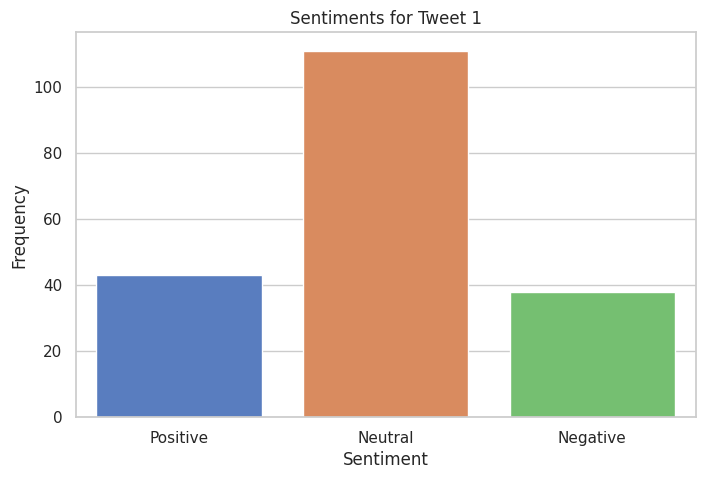

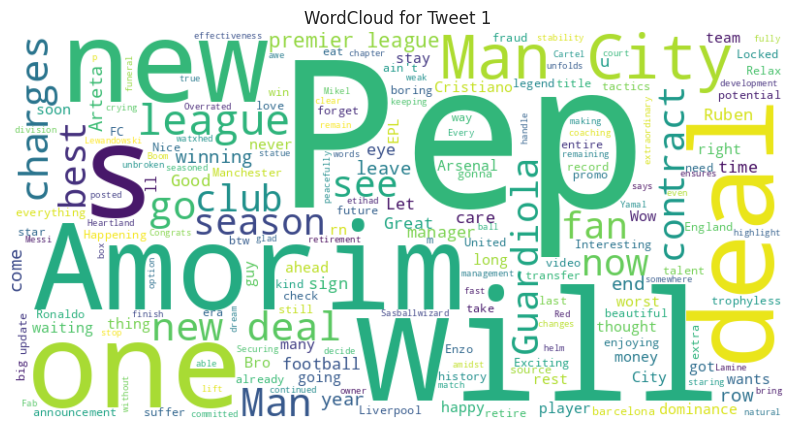

Generando gráficos para el Tweet Principal 2:  Paris Saint-Germain are closing in on the agreement with Nuno Mendes over new deal!

Final details being sorted as the new contract will be valid until June 2029, part of Luis Campos plans as PSG trust Nuno for the future.

Hakimi and Nuno, both extending.


<ipython-input-5-f49a721e3197>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="muted")


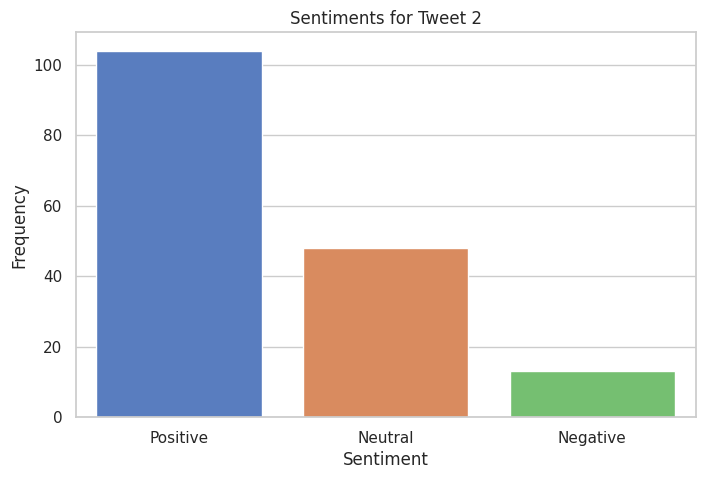

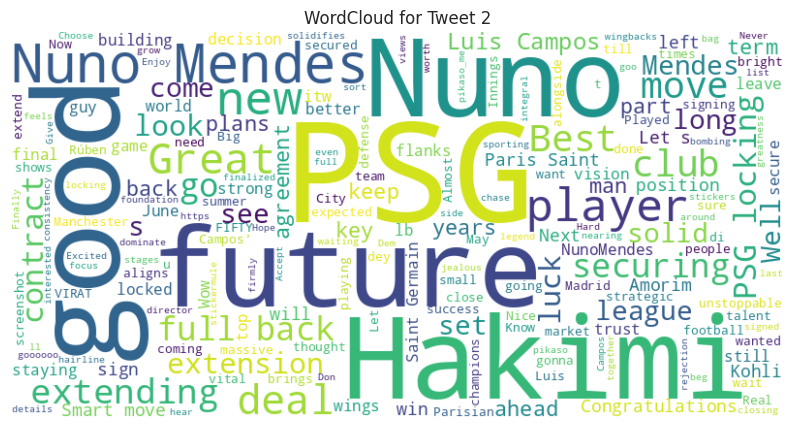

Generando gráficos para el Tweet Principal 3:  OFFICIAL: Pep Guardiola signs new deal at Manchester City, as planned.

Agreement valid until June 2027 for Pep as he’s crucial part of Man City project.


<ipython-input-5-f49a721e3197>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="muted")


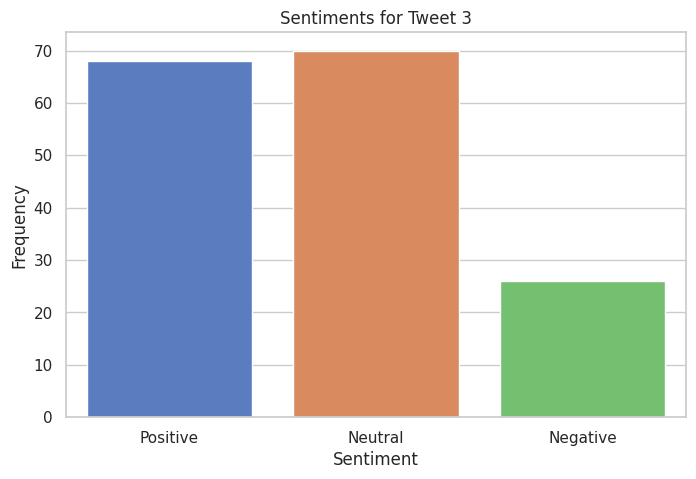

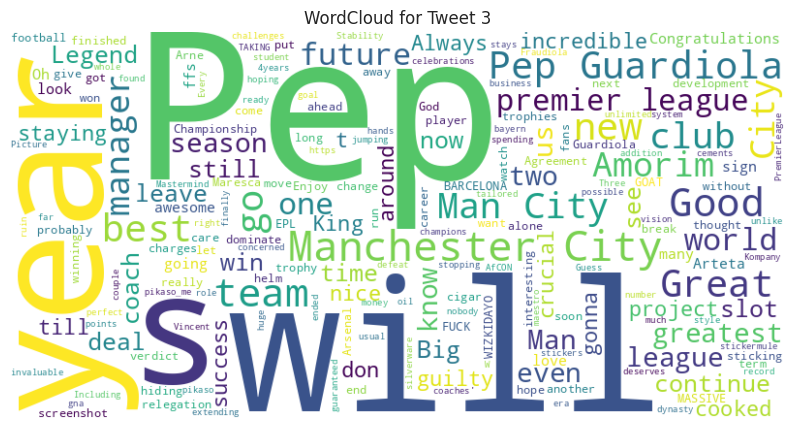

Generando gráficos para el Tweet Principal 4:  Pep Guardiola: “It took two hours to agree on new deal with Man City board”.

“All my decisions have been in my life have been like that; what I feel at that moment”.


<ipython-input-5-f49a721e3197>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="muted")


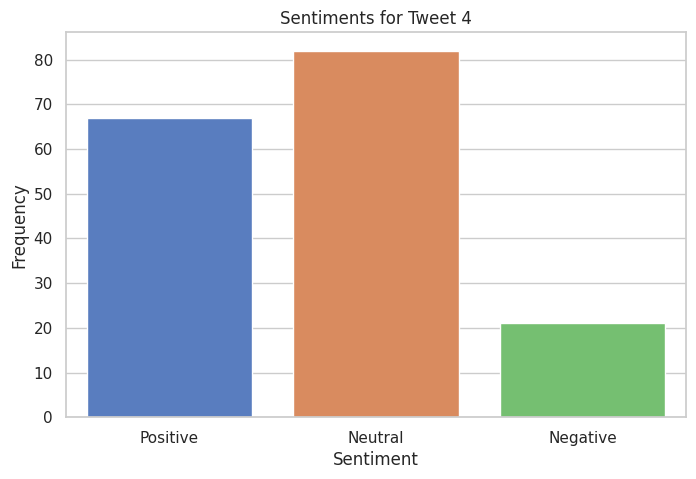

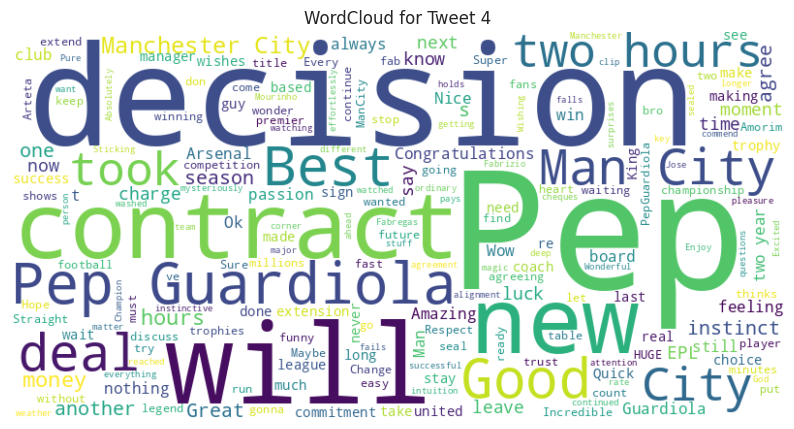

Generando gráficos para el Tweet Principal 5: Pepppppppppp! Mancity love you. 
We love youuuuuuu!


<ipython-input-5-f49a721e3197>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="muted")


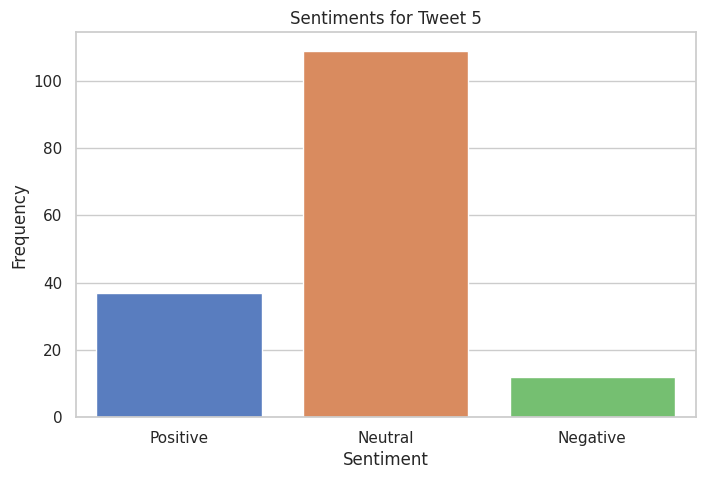

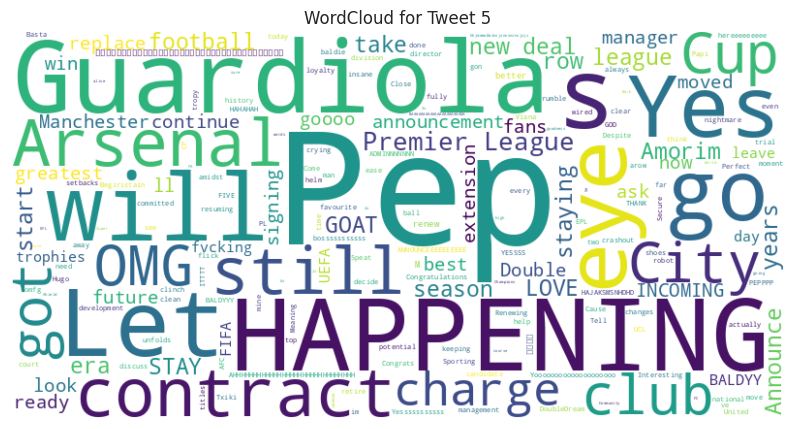

Generando gráficos para el Tweet Principal 6:  Bayern director Max Eberl on Leon Goretzka: “We will discuss what the future holds with him again”.

“We spoke to Goretzka in the summer and he decided to stay. We are happy that he's here”.

“He's an important part of the team”.


<ipython-input-5-f49a721e3197>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="muted")


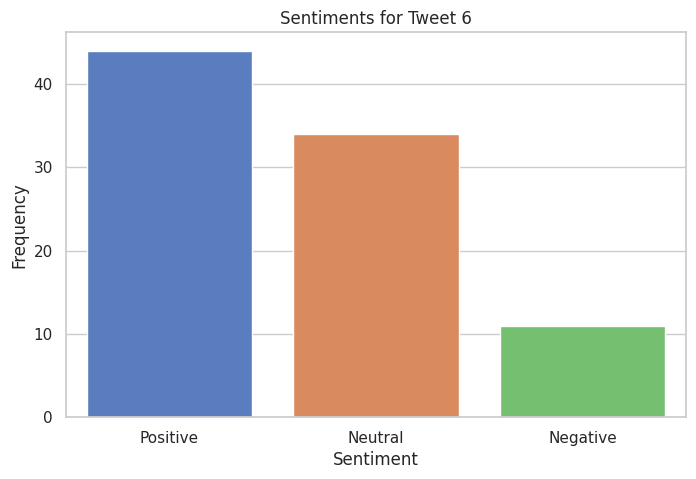

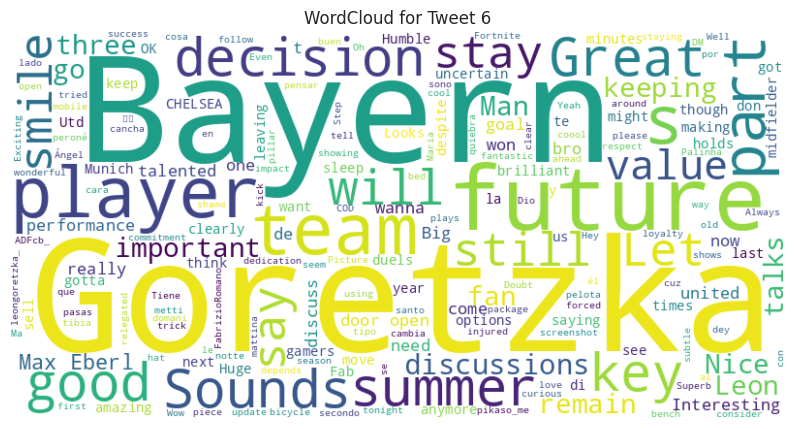

Generando gráficos para el Tweet Principal 7:  Rodri on potential future Real Madrid call: “When Real Madrid call you, the best club in history and the most successful… it makes you proud and you always have to listen”.

“It’s obvious. You always have to pay attention”, told 
@ellarguero
.


<ipython-input-5-f49a721e3197>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="muted")


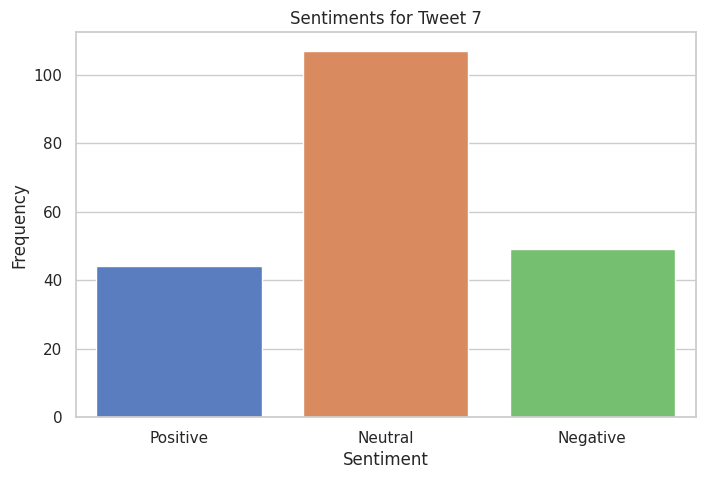

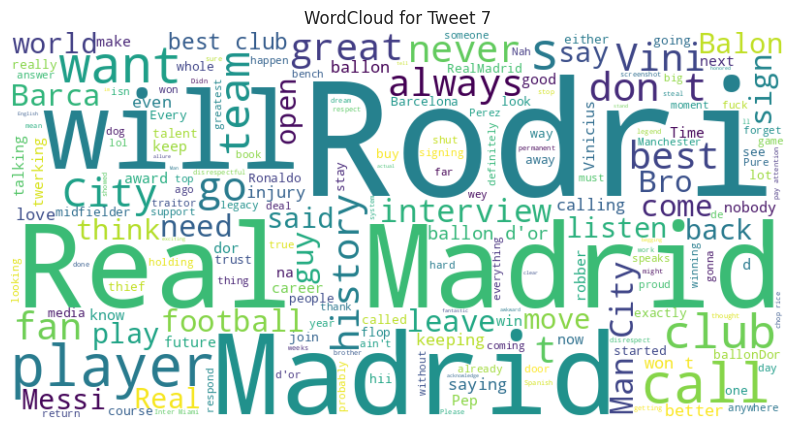

Generando gráficos para el Tweet Principal 8:  Achraf Hakimi captains PSG tonight after signing new contract at the club until June 2029.




<ipython-input-5-f49a721e3197>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="muted")


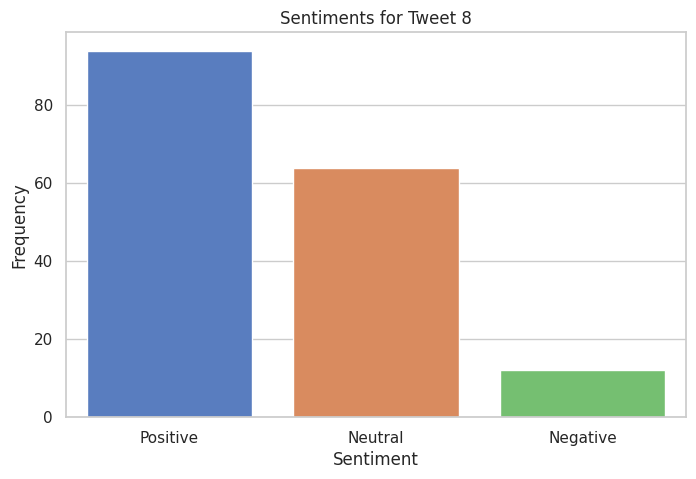

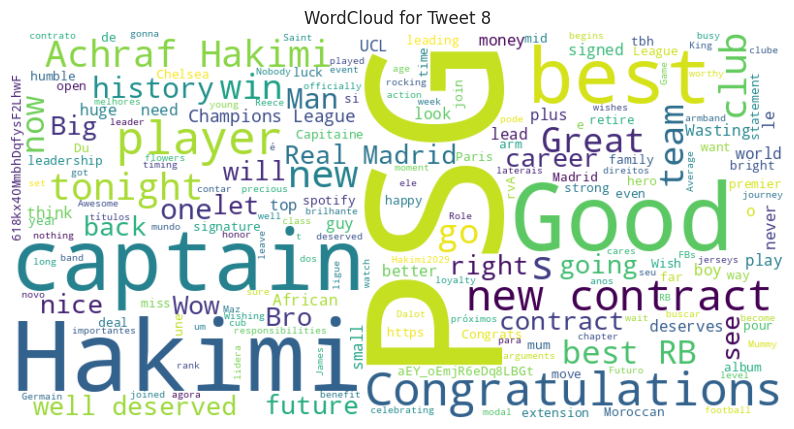

Generando gráficos para el Tweet Principal 9:  All documents are in place for Denzel Dumfries new deal at Inter valid until June 2028.

Agreement reached months ago and now also set to be formally announced.


<ipython-input-5-f49a721e3197>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="muted")


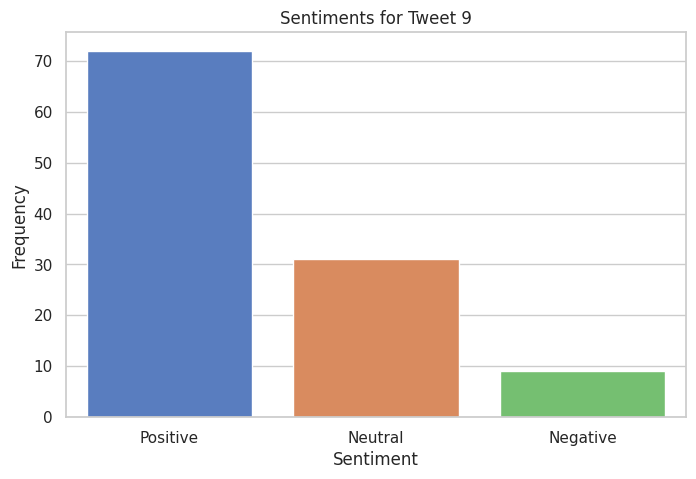

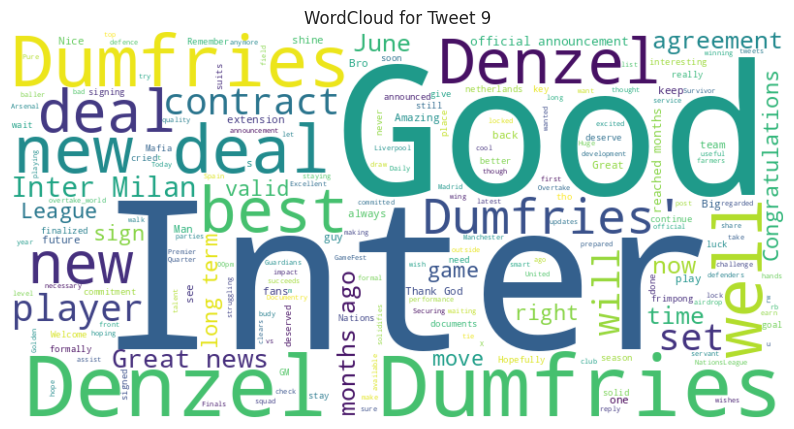

Generando gráficos para el Tweet Principal 10:  Javier Mascherano will be officially announced as new Inter Miami manager in the upcoming days.

All documents are in place, three year deal for Mascherano who’s gonna work with Messi again.

Diego Placente replaces Mascherano as Argentina U20 head coach.


<ipython-input-5-f49a721e3197>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="muted")


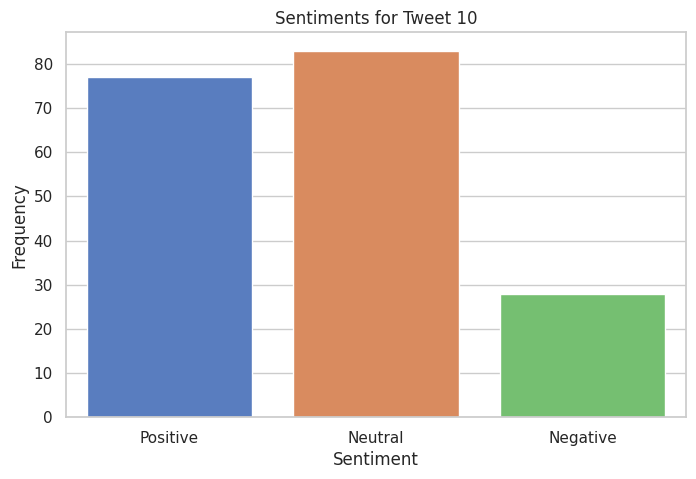

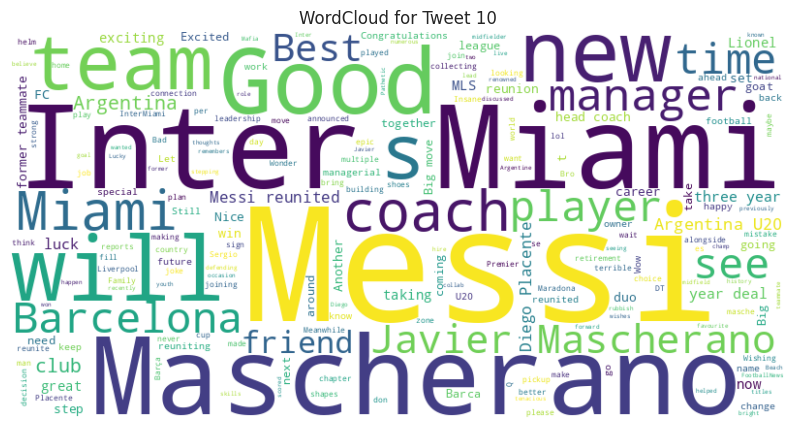

Generando gráficos para todas las respuestas combinadas...


<ipython-input-5-f49a721e3197>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="muted")


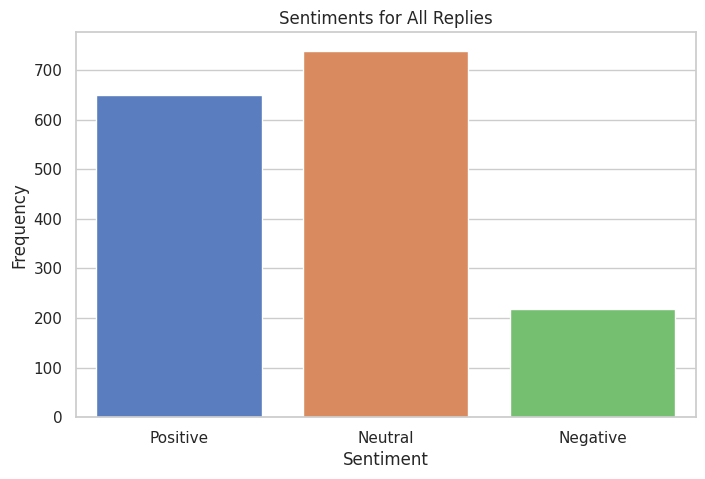

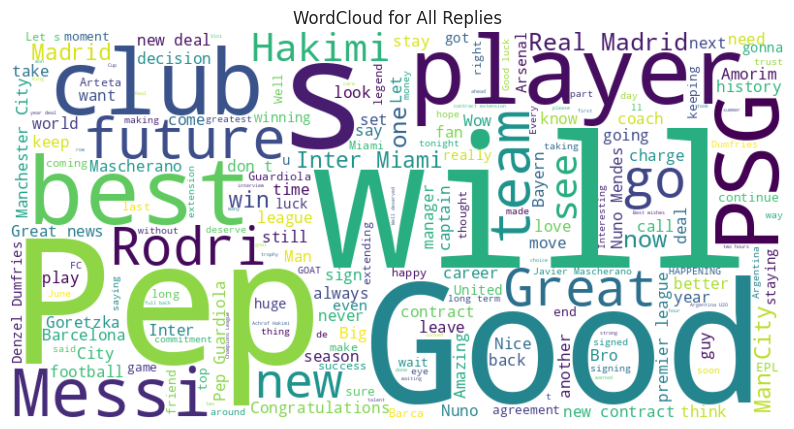

Análisis completado. Resultados guardados en 'data_with_sentiments.csv'.


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo preentrenado para análisis de sentimientos en Twitter
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

# Etiquetas del modelo
labels_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

# Función para preprocesar texto
def preprocess_text(text):
    return text[:512].strip()

# Función para predecir sentimientos en lotes
def predict_sentiments_in_batches(texts, batch_size=8):
    sentiments = []
    print("Iniciando predicciones en lotes...")
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        print(f"Procesando lote {i // batch_size + 1}/{len(texts) // batch_size + 1}...")
        try:
            inputs = tokenizer(
                batch,
                return_tensors="pt",
                truncation=True,
                max_length=512,
                padding="max_length"
            ).to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
                labels = torch.argmax(probabilities, dim=1)
            sentiments.extend([labels_map[label.item()] for label in labels])
        except Exception as e:
            sentiments.extend(["Error"] * len(batch))
            print(f"Error procesando el lote: {e}")
    return sentiments

# Gráfico de barras
def plot_sentiment_bar(sentiments, title):
    sns.set(style="whitegrid")
    sentiment_counts = pd.Series(sentiments).value_counts()
    sentiment_counts = sentiment_counts.reindex(["Positive", "Neutral", "Negative"], fill_value=0)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="muted")
    plt.title(title)
    plt.ylabel("Frequency")
    plt.xlabel("Sentiment")
    plt.show()

# Nube de palabras
def plot_wordcloud(texts, title):
    text_combined = " ".join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_combined)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Función principal
def analyze_sentiments(csv_file):
    data = pd.read_csv(csv_file)
    data["Reply"] = data["Reply"].apply(preprocess_text)

    # Analizar sentimientos
    print("Analizando sentimientos...")
    data["Sentiment"] = predict_sentiments_in_batches(data["Reply"].tolist(), batch_size=4)

    # Gráficos para cada tweet principal
    unique_tweets = data["Tweet"].unique()
    for i, tweet in enumerate(unique_tweets, start=1):
        print(f"Generando gráficos para el Tweet Principal {i}: {tweet}")
        replies = data[data["Tweet"] == tweet]["Reply"].tolist()
        sentiments = data[data["Tweet"] == tweet]["Sentiment"].tolist()

        plot_sentiment_bar(sentiments, f"Sentiments for Tweet {i}")
        plot_wordcloud(replies, f"WordCloud for Tweet {i}")

    # Gráficos combinados para todas las respuestas
    print("Generando gráficos para todas las respuestas combinadas...")
    all_replies = data["Reply"].tolist()
    all_sentiments = data["Sentiment"].tolist()

    plot_sentiment_bar(all_sentiments, "Sentiments for All Replies")
    plot_wordcloud(all_replies, "WordCloud for All Replies")

    data.to_csv("data_with_sentiments.csv", index=False, encoding="utf-8")
    print("Análisis completado. Resultados guardados en 'data_with_sentiments.csv'.")

# Ejecutar el análisis
analyze_sentiments("tweets_and_replies.csv")


In [ ]:
!pip install pandas matplotlib networkx pyvis seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network

In [ ]:
# Cargar el archivo CSV con tweets y respuestas
tweets_file = "/content/sample_data/tweets_and_replies (1).csv"
sentiment_file = "/content/sample_data/data_with_sentiments.csv"

# Leer los datos
tweets_data = pd.read_csv(tweets_file)
sentiment_data = pd.read_csv(sentiment_file)

# Revisar las primeras filas para entender la estructura
print(tweets_data.head())
print(sentiment_data.head())


                Tweet                                              Reply
0  New deal for Pep.                                      Its Happening 
1  New deal for Pep.        He wants to lift the league before he leaves
2  New deal for Pep.   So happy  \n\nNo Red Cartel club wins the titl...
3  New deal for Pep.          who else thought that Fab has posted p@rn?
4  New deal for Pep.                                         Here we go!
                Tweet                                              Reply  \
0  New deal for Pep.                                       Its Happening   
1  New deal for Pep.        He wants to lift the league before he leaves   
2  New deal for Pep.   So happy  \n\nNo Red Cartel club wins the titl...   
3  New deal for Pep.          who else thought that Fab has posted p@rn?   
4  New deal for Pep.                                         Here we go!   

  Sentiment  
0   Neutral  
1   Neutral  
2  Positive  
3   Neutral  
4  Positive  


In [ ]:
import re
from collections import Counter

# Función para extraer nombres propios
def extract_names(text):
    return re.findall(r'\b[A-Z][a-z]+\b', str(text))

# Extraer nombres desde los tweets y respuestas
tweets_data['Extracted_Names'] = tweets_data['Tweet'].apply(extract_names) + tweets_data['Reply'].apply(extract_names)

# Contar frecuencia de menciones
all_names = [name for sublist in tweets_data['Extracted_Names'] for name in sublist]
name_counts = Counter(all_names)

# Convertir a DataFrame
name_df = pd.DataFrame(name_counts.items(), columns=['Name', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Filtrar nombres irrelevantes
common_terms = ["June", "City", "Who", "Here", "You", "Red", "So", "No", "He", "And", "The"]
filtered_names = name_df[~name_df['Name'].isin(common_terms)].head(20)  # Los 20 más frecuentes
print(filtered_names)


           Name  Frequency
1           Pep        807
663  Mascherano        603
159        Nuno        538
111         All        480
189      Madrid        473
58           We        462
188        Real        440
27           It        401
165      Hakimi        384
34          Man        376
28    Guardiola        372
517       Inter        357
266   Agreement        280
46        Messi        256
461       Rodri        249
518       Miami        232
362        When        207
666   Argentina        206
662      Javier        200
430    Goretzka        198


In [ ]:
# Mapear sentimientos del archivo de sentimientos
player_sentiments = []

for name in filtered_names['Name']:
    # Filtrar respuestas relevantes
    relevant_rows = sentiment_data[sentiment_data['Reply'].str.contains(name, na=False, case=False)]

    # Mapear sentimientos (Negative=-1, Neutral=0, Positive=1)
    sentiment_mapping = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
    avg_sentiment = None
    if not relevant_rows.empty:
        sentiments_numeric = relevant_rows['Sentiment'].map(sentiment_mapping)
        avg_sentiment = sentiments_numeric.mean()

    # Agregar datos del jugador
    player_sentiments.append({
        'Name': name,
        'Frequency': filtered_names.loc[filtered_names['Name'] == name, 'Frequency'].values[0],
        'Average_Sentiment': avg_sentiment
    })

# Convertir a DataFrame
player_sentiments_df = pd.DataFrame(player_sentiments).sort_values(by='Average_Sentiment', ascending=False)
print(player_sentiments_df)


          Name  Frequency  Average_Sentiment
2         Nuno        538           0.771429
17   Argentina        206           0.722222
8       Hakimi        384           0.700000
1   Mascherano        603           0.588235
19    Goretzka        198           0.578947
18      Javier        200           0.500000
11       Inter        357           0.435294
12   Agreement        280           0.363636
10   Guardiola        372           0.350000
0          Pep        807           0.345588
7           It        401           0.297003
9          Man        376           0.286667
15       Miami        232           0.279070
6         Real        440           0.225806
5           We        462           0.225166
16        When        207           0.217391
3          All        480           0.196203
13       Messi        256           0.175676
4       Madrid        473           0.108108
14       Rodri        249           0.061224


In [ ]:
# Crear el grafo
G = nx.Graph()

# Agregar nodos con atributos
for _, row in player_sentiments_df.iterrows():
    G.add_node(
        row['Name'],
        size=row['Frequency'],
        sentiment=row['Average_Sentiment']
    )

# Crear aristas basadas en menciones conjuntas
for _, row in sentiment_data.iterrows():
    mentioned_players = [name for name in filtered_names['Name'] if name in row['Reply']]
    for i in range(len(mentioned_players)):
        for j in range(i + 1, len(mentioned_players)):
            if G.has_edge(mentioned_players[i], mentioned_players[j]):
                G[mentioned_players[i]][mentioned_players[j]]['weight'] += 1
            else:
                G.add_edge(mentioned_players[i], mentioned_players[j], weight=1)


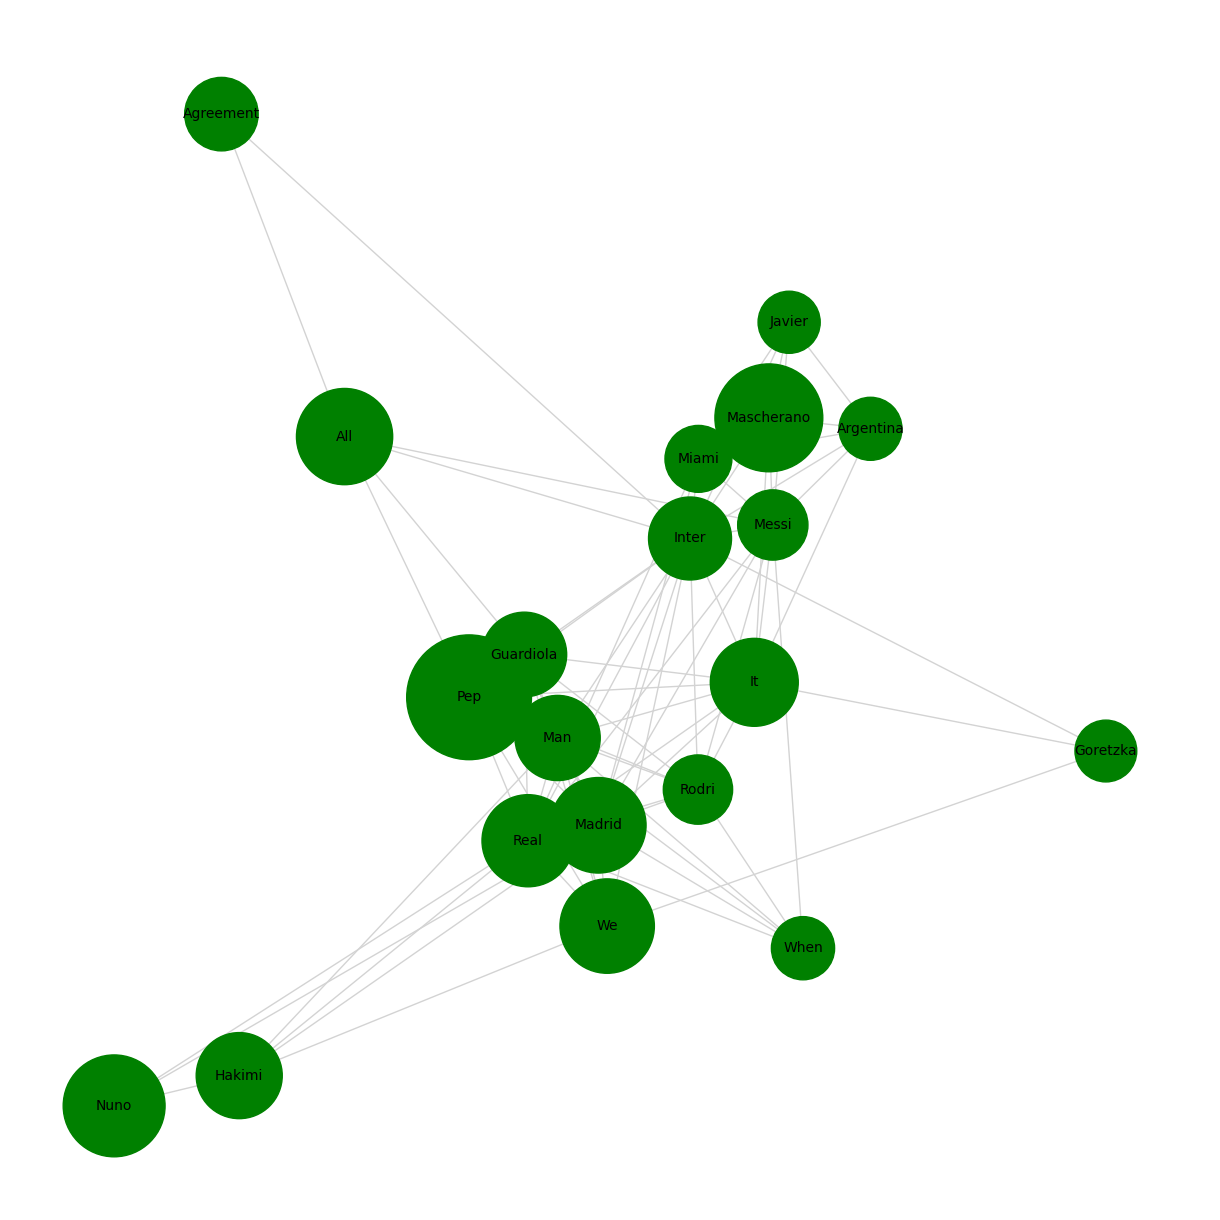

In [ ]:
# Dibujar el grafo estático
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Layout del grafo
sizes = [G.nodes[node]['size'] * 10 for node in G.nodes]  # Tamaño por frecuencia
colors = [
    'green' if G.nodes[node].get('sentiment') > 0 else
    'red' if G.nodes[node].get('sentiment') < 0 else
    'gray'
    for node in G.nodes
]

nx.draw(
    G, pos, with_labels=True, node_size=sizes, node_color=colors, edge_color='lightgray', font_size=10
)
plt.show()
